In [1]:
#importing the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings("ignore")
import imblearn

In [2]:
#loading the data
data=pd.read_csv("2yrs_stock_history.csv")

In [3]:
#shape of data
data.shape

(4950, 11)

In [4]:
#shape of data
data.shape

(4950, 11)

In [5]:
#companies we have in the dataset
companies=data['Stock'].unique()
print(companies)

['AAPL' 'CSCO' 'GD' 'GOOG' 'LIN' 'MSFT' 'NVDA' 'RTX' 'TSLA' 'FDX']


In [6]:
data.describe()
# # we will see here the mean, median, percentiles for all the coulmns

,Open,High,Low,Close,Trade_count,Vwap,MA,Recommendation,stock_num
count,4950.000000,4950.000000,4950.000000,4950.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4950.000000
mean,190.635412,193.212414,188.070355,190.712298,2.967889e+05,190.674479,190.285171,1.746465,5.500000
std,87.532495,88.715526,86.264124,87.519777,3.547390e+05,87.495888,86.831958,0.597836,2.872571
min,38.430000,39.250000,38.010000,38.670000,9.283000e+03,38.870000,39.889000,0.000000,1.000000
25%,116.597500,118.791250,114.960075,116.972500,4.051275e+04,116.850000,116.743250,2.000000,3.000000
50%,194.360000,197.110000,191.680000,194.665000,1.175950e+05,194.202474,193.864000,2.000000,5.500000
75%,257.182500,259.875000,252.877500,257.035000,4.759052e+05,256.897500,256.645250,2.000000,8.000000
max,435.010000,439.900000,426.740000,438.080000,2.631367e+06,432.741129,410.465000,2.000000,10.000000


In [7]:
#let's check if there is any duplicate data
print(data.duplicated().any())
print(data.duplicated().sum())

False
0


In [8]:
#let's drop all the duplicates values
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(4950, 11)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 4949
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4950 non-null   object 
 1   Open            4950 non-null   float64
 2   High            4950 non-null   float64
 3   Low             4950 non-null   float64
 4   Close           4950 non-null   float64
 5   Trade_count     4950 non-null   int64  
 6   Vwap            4950 non-null   float64
 7   MA              4950 non-null   float64
 8   Recommendation  4950 non-null   int64  
 9   Stock           4950 non-null   object 
 10  stock_num       4950 non-null   int64  
dtypes: float64(6), int64(3), object(2)
memory usage: 464.1+ KB


In [11]:
# we have Recommendation feature as a target variable, now lets impute
# missing values
print(data['Recommendation'].isnull().sum())
#empty values here that the user should hold the stocks.
#lets will the empty values with "Hold"
data['Recommendation']=data["Recommendation"].fillna("2")

#2 = #hold
#1 = #buy
#0 = #sell

0


In [12]:
print(data['Recommendation'].isnull().sum())
#now we dont have any null value

0


2    4111
1     423
0     416
Name: Recommendation, dtype: int64


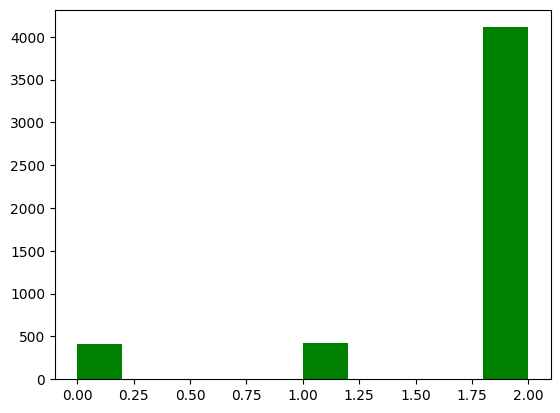

In [13]:
#Recommendation is our target variable
#Lets see if there is class imbalace or not

print(data['Recommendation'].value_counts())
plt.hist(data['Recommendation'], facecolor='g')
plt.show()

In [14]:

#lets see this imbalance data in depth
#CLASS LABELS PERCENTAGE In WHOLE DATA
a=416/data.shape[0]*100 #sell
b=423/data.shape[0]*100 #buy
c=4111/data.shape[0]*100 #hold
print("Percenatage of Sell in data " +str(a)+"%")
print("Percenatage of Buy in data " +str(b)+"%")
print("Percentage of Hold in data " +str(c)+"%")

Percenatage of Sell in data 8.404040404040405%
Percenatage of Buy in data 8.545454545454545%
Percentage of Hold in data 83.05050505050505%


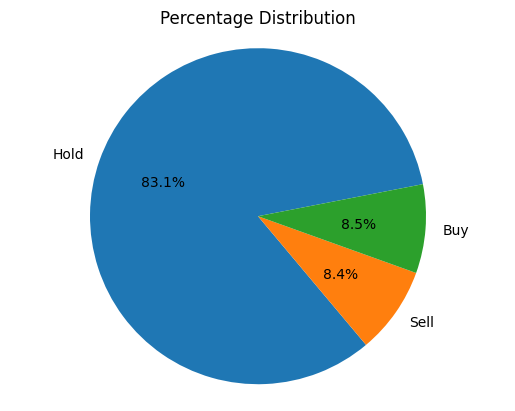

In [15]:
#LETS PLOT THE PIE CHART TO SEE THE DISTRIBUTION
label = 'Hold','Sell','Buy'
percent = [ 83.05, 8.40,8.54 ]

fig1, ax1 = plt.subplots()
ax1.pie(percent ,labels=label, autopct='%1.1f%%',
        shadow=False, startangle=11)
ax1.axis('equal')
plt.title("Percentage Distribution")
plt.show()

#Dimension Reduction

##Feature- 'Date'
We took data for last years but there are some companies in the data which got listed in these 2 years so there will be a mismatch in data rows between companies.

Also this project is motivated to work around Momentum Trading and that is the reason the "Recommendation" column which is added by a Rule Based System and by some manual observation has no relation with the feature "Date", so for this project we won't include Date as a feature.

In [16]:
#we took only important features which were used to derive rule based system
df=data[['Recommendation','Close', 'Open','High','Low','stock_num']]

In [17]:
df.shape

(4950, 6)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 4949
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recommendation  4950 non-null   int64  
 1   Close           4950 non-null   float64
 2   Open            4950 non-null   float64
 3   High            4950 non-null   float64
 4   Low             4950 non-null   float64
 5   stock_num       4950 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 270.7 KB


In [19]:
df['Recommendation'].value_counts()

2    4111
1     423
0     416
Name: Recommendation, dtype: int64

In [20]:
y=df.iloc[:,0:1]
X=df.iloc[:,1:9]

In [21]:
X.columns #feature names

Index(['Close', 'Open', 'High', 'Low', 'stock_num'], dtype='object')

In [22]:
y.columns #this is the target variable

Index(['Recommendation'], dtype='object')

In [23]:
#spliting the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [24]:
print(X_train.shape)
print(y_train.shape)

(3465, 5)
(3465, 1)


In [25]:
print(X_test.shape)
print(y_test.shape)

(1485, 5)
(1485, 1)


In [26]:
y_train['Recommendation'].value_counts()

2    2875
1     298
0     292
Name: Recommendation, dtype: int64

Test data is to test the performance of the the Machine Learning model.

Here we are using SMOTE technique on training data, SMOTE algorithm synthetically produces samples using KNN(K nearest neighbour) algorithm, so it understands the local behaviour of a particular class label and try to produce synthetic rows according to that behaviour.

In [27]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
strategy = {1:500, 2:2875, 0:500}
#we want Buy and Sell rows to be 2500 and Strong Buy and Strong Sell to be 1500
oversample = SMOTE(sampling_strategy=strategy)
Xsmote, ysmote = oversample.fit_resample(X_train, y_train)

In [28]:
print(Xsmote.shape)
print(ysmote.shape)
# print(ysmote)

(3875, 5)
(3875, 1)


We still have data imabalance in the data but that is the nature of original data we have in real world, We can do more balancing of data but then Machine Learning model wont be able to handle that in real world data.

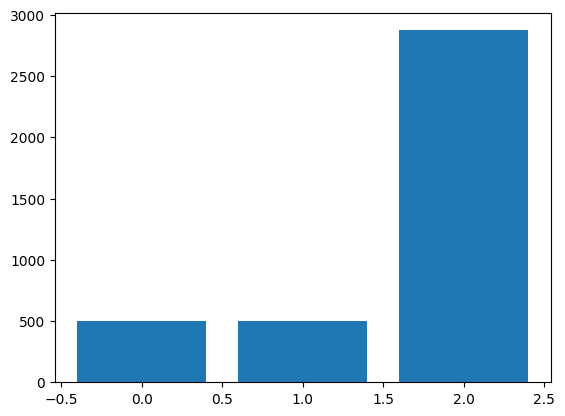

In [29]:
# Plot the distribution
plt.bar([0,1,2], [500,500,2875])
plt.show()

Logistic Regression(SMOTE)

In [30]:
#we are using simple gridsearchcv to tune the hyperparameter C
#here we are using smote samples
tuned_parameters=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]

LRmodel=GridSearchCV(LogisticRegression(max_iter=400),tuned_parameters)

LRmodel.fit(Xsmote,ysmote)

print(LRmodel.best_estimator_)
print(LRmodel.score(X_test,y_test))

LogisticRegression(C=0.0001, max_iter=400)
0.8323232323232324


In [31]:
#predictions
LR_testsmote_prediction=LRmodel.predict(X_test)
LR_trainsmote_predictions=LRmodel.predict(Xsmote)

In [32]:
#evaluation of Logistic Regression with smote
from sklearn.metrics import f1_score
X_lrtest_F1score=f1_score(y_test,LR_testsmote_prediction,average='macro')
print("Testing f1 score is",X_lrtest_F1score) #f1 score on test data

X_lrtrain_F1score=f1_score(ysmote,LR_trainsmote_predictions,average='macro')
print("Training f1 score is",X_lrtrain_F1score) #f1 score on train data

Testing f1 score is 0.302829841969864
Training f1 score is 0.28651009370060515


F1_macro is really very bad, it means model is not able to classify minority class labels.

#Logistic Regression

In [33]:
#we are using simple gridsearchcv to tune the hyperparameter C
#here we are not using smote samples
tuned_parameters=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]

LRmodel=GridSearchCV(LogisticRegression(max_iter=400),tuned_parameters)

LRmodel.fit(X_train,y_train)

print(LRmodel.best_estimator_)
print(LRmodel.score(X_test,y_test))

LogisticRegression(C=0.0001, max_iter=400)
0.8323232323232324


In [34]:
#predictions
LR_test_prediction=LRmodel.predict(X_test)
LR_train_predictions=LRmodel.predict(X_train)

In [35]:
#evaluation of Logistic Regression without smote
from sklearn.metrics import f1_score
X_lrtest_F1score=f1_score(y_test,LR_test_prediction,average='macro')
print("Testing f1 score is",X_lrtest_F1score) #f1 score on test data

X_lrtrain_F1score=f1_score(y_train,LR_train_predictions,average='macro')
print("Training f1 score is",X_lrtrain_F1score) #f1 score on train data

Testing f1 score is 0.302829841969864
Training f1 score is 0.30231335436382756


#Random Forest(smote)
Lets begin the model training, we will start with Random Forest Model

In [36]:
#Training random forest after applying SMOTE technique.
#here we are using GridSearchCV to tune the hyperparamters we have in randomforest to see which
# parameters works best.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200,300, 500],
    'max_depth' : [4,5,6]
}
rfc=RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [37]:
#here we are fiting the training data

grid_search.fit(Xsmote, ysmote)
print(grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 6, 'n_estimators': 300}


In [38]:
#training the random forest model
rfc_new=RandomForestClassifier(criterion= 'entropy', max_depth= 6, max_features= 'auto', n_estimators=200,random_state=42)
random_forest_model_smote=rfc_new.fit(Xsmote,ysmote)

In [39]:
#predictions
smote_predictions_test=random_forest_model_smote.predict(X_test)
smote_predictions_train=random_forest_model_smote.predict(Xsmote)

In [40]:
#evaluation of random forest with smote
from sklearn.metrics import f1_score
X_test_F1score=f1_score(y_test,smote_predictions_test,average='micro')
print("Testing f1 score is",X_test_F1score) #f1 score on test data

X_train_F1score=f1_score(ysmote,smote_predictions_train,average='micro')
print("Training f1 score is",X_train_F1score) #f1 score on train data

Testing f1 score is 0.8323232323232324
Training f1 score is 0.7447741935483871


#RandomForest

In [41]:
#lets train random forest without using smote technique

#here we are GridSearchCV to tune the hyperparamters we have in randomforest to see which
# parameters works best.
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [200,300, 500],
    'max_depth' : [4,5,6]
}
rfc3=RandomForestClassifier(class_weight='balanced',random_state=42)
#here parameter class_weight='balanced' will balance the class imbalances

grid_searchcw = GridSearchCV(estimator = rfc3, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [42]:
grid_searchcw.fit(X_train, y_train)
print(grid_searchcw.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
{'max_depth': 6, 'n_estimators': 300}


In [43]:
#training rf with tuned parameters(only class weights)
from sklearn.ensemble import RandomForestClassifier
rfc3=RandomForestClassifier(class_weight='balanced',criterion= 'entropy', max_depth= 6, max_features= 'auto', n_estimators=300,random_state=42)
random_forest_modelcw=rfc3.fit(X_train,y_train)

In [44]:
X_test_predictcw=random_forest_modelcw.predict(X_test)
X_train_predictcw=random_forest_modelcw.predict(X_train)

In [45]:
#class weights
from sklearn.metrics import f1_score
X_test_F1score=f1_score(y_test,X_test_predictcw,average='micro')
print("Test F1 score for random forest is",X_test_F1score) #f1 score on test data

X_train_F1score=f1_score(y_train,X_train_predictcw,average='micro')
print("Train F1 score for random forest is",X_train_F1score) #f1 score on train data

Test F1 score for random forest is 0.6424242424242425
Train F1 score for random forest is 0.7927849927849928


In [46]:
print(X_test[:5])
# random_forest_modelcw.predict()

       Close     Open      High      Low  stock_num
230   147.83  149.020  150.8400  146.800          1
4855  212.25  209.850  213.5100  209.040         10
1954  116.96  116.490  118.7950  116.480          4
3463  438.08  429.980  439.9000  426.740          7
1844   99.87   99.815  101.7499   99.355          4


In [47]:
from prettytable import PrettyTable
columns=(["ALGORITHM", "F1_SCORE"])
myTable = PrettyTable()
myTable.add_column(columns[0], ["Logistic Regression with smote","Logistic Regression","Random Forest with smote" ,"Random Forest"])
myTable.add_column(columns[1], [" 32.28%","30.28%"," 74.50%", "64.24%"])

print(myTable)


+--------------------------------+----------+
|           ALGORITHM            | F1_SCORE |
+--------------------------------+----------+
| Logistic Regression with smote |  32.28%  |
|      Logistic Regression       |  30.28%  |
|    Random Forest with smote    |  74.50%  |
|         Random Forest          |  64.24%  |
+--------------------------------+----------+
